# ProstMorph
MRI/US fusion using VoxelMorph

In [1]:
from pathlib import Path

import neurite as ne
import numpy as np
import tensorflow as tf

from notebooks.utils import SmartDataGenerator, split_dataset, dice_coeff, prepare_model
import matplotlib.pyplot as plt
import seaborn as sns

### Build model

Create dataset generators, instantiate the network and load the model

In [15]:
seed = 24052022
base_folder = Path(r"C:\Users\ML\Desktop\seba_preprocessed_fusion\numpy_160")
train_data, validation_data, test_data = split_dataset(base_folder, train_test_split=0.95, train_val_split=0.90, seed=seed)

size = (160, 160, 160)
train_generator = SmartDataGenerator(train_data, dim=size, batch_size=1, seed=seed)
validation_generator = SmartDataGenerator(validation_data, dim=size, batch_size=1, seed=seed)
test_generator = SmartDataGenerator(test_data, dim=size, batch_size=1, seed=seed)

In [ ]:
hyper = {
    'lambda_param': 5.0,
    'gamma_param': 3.0
}
model = prepare_model(inshape=size, lambda_param=hyper['lambda_param'], gamma_param=hyper['gamma_param'])

In [11]:
checkpoints_dir = Path(f"../models/test_{hyper['lambda_param']}_{hyper['gamma_param']}/checkpoints")
latest_checkpoint = tf.train.latest_checkpoint(checkpoints_dir)
model.load_weights(latest_checkpoint)

Collect dice and TRE results after target deformation

In [18]:
from tqdm import tqdm
from skimage import measure

def create_and_store_results(generator, lambda_param, gamma_param):
    results = {
        "prostate_dice": [], "target_dice": [], "target_error": [],
        "prostate_dice_def": [], "target_dice_def": [], "target_error_def": []
    }
    for idx in tqdm(range(len(generator))):
        test_input, test_output, mr_targets, us_targets, _ = generator(idx)

        mr_targets = mr_targets[0]
        us_targets = us_targets[0]

        test_pred = model.predict(test_input)
        prostate_dice_val = dice_coeff(test_pred[2], test_output[2])
        results["prostate_dice"].append(prostate_dice_val)
        prostate_dice_def_val = dice_coeff(test_pred[2], test_input[2])
        results["prostate_dice_def"].append(prostate_dice_def_val)

        if mr_targets is None or us_targets is None:
            print("no matching targets here")
            continue

        for select_target in range(min(mr_targets.shape[-1], us_targets.shape[-1])):
            test_input_target = mr_targets[np.newaxis, ..., [select_target]]
            test_output_target = us_targets[np.newaxis, ..., [select_target]]
            test_pred_target = model.apply_transform(test_input[0], test_input[1], test_input_target)

            # in "error" we use /2 because images have an isotropic spacing of 0.5 mm, meaning that the distance is double its size

            # Dice between target in MR_def and US
            target_dice_val = dice_coeff(test_pred_target, test_output_target)
            target_error_val = np.linalg.norm((measure.centroid(test_pred_target) - measure.centroid(test_output_target)) / 2)
            results["target_dice"].append(target_dice_val)
            results["target_error"].append(target_error_val)

            # Dice between target in MR and MR_def
            target_dice_val = dice_coeff(test_pred_target, test_input_target)
            target_error_val = np.linalg.norm((measure.centroid(test_pred_target) - measure.centroid(test_input_target)) / 2)
            results["target_dice_def"].append(target_dice_val)
            results["target_error_def"].append(target_error_val)

    # convert everything to ndarray
    for k in results.keys():
        results[k] = np.array(results[k])

    # store results
    np.savez_compressed(f"../results/results_{lambda_param}_{gamma_param}", results)

Run for a single model

In [ ]:
create_and_store_results(test_generator, hyper['lambda_param'], hyper['gamma_param'])

Run for all the models

In [ ]:
model = prepare_model(inshape=size, lambda_param=0, gamma_param=0)
for checkpoints_dir in Path(f"../models").iterdir():
    _, lambda_param, gamma_param = checkpoints_dir.name.split("_")
    latest_checkpoint = tf.train.latest_checkpoint(checkpoints_dir / "checkpoints")
    model.load_weights(latest_checkpoint)

    create_and_store_results(test_generator, lambda_param, gamma_param)

vxm info: mutual information loss is experimental
 28%|██▊       | 27/96 [04:33<14:37, 12.72s/it]C:\Users\ML\AppData\Local\Programs\Python\Python37\lib\site-packages\skimage\measure\_moments.py:359: RuntimeWarning: invalid value encountered in true_divide
  / M[(0,) * image.ndim])  # weighted sum of all points
 42%|████▏     | 40/96 [06:40<08:10,  8.77s/it]

Print and plot stats

In [34]:
results = np.load(f"../results/results_5.0_2.0.npz", allow_pickle=True)['arr_0'].tolist()

In [ ]:
good_dice_threshold = 0.25

valid_dice = results['dice'][np.isfinite(results['dice'])]
valid_error = results['error'][np.isfinite(results['error'])]
good_dice = results['dice'][results['dice'] > good_dice_threshold]
good_error = results['error'][results['dice'] > good_dice_threshold]
decent_dice = results['dice'][results['dice'] > 0]
decent_error = results['error'][results['dice'] > 0]
bad_dice = results['dice'][results['dice'] == 0]
bad_error = results['error'][results['dice'] == 0]

print(f"#targets valid dice: {len(valid_dice) / len(results['dice']) * 100:.2f}%")
print(f"target valid dice: {valid_dice.mean() * 100:.2f}±{valid_dice.std() * 100:.2f}%")
print(f"target valid error: {valid_error.mean():.2f}±{valid_error.std():.2f}mm")
print()
print(f"#targets good dice: {len(good_dice) / len(results['dice']) * 100:.2f}%")
print(f"target good dice: {good_dice.mean() * 100:.2f}±{good_dice.std() * 100:.2f}%")
print(f"target good error: {good_error.mean():.2f}±{good_error.std():.2f}mm")
print()
print(f"#targets decent dice: {len(decent_dice) / len(results['dice']) * 100:.2f}%")
print(f"target decent dice: {decent_dice.mean() * 100:.2f}±{decent_dice.std() * 100:.2f}%")
print(f"target decent error: {decent_error.mean():.2f}±{decent_error.std():.2f}mm")
print()
print(f"#targets bad dice: {len(bad_dice) / len(results['dice']) * 100:.2f}%")
print(f"target bad dice: {bad_dice.mean() * 100:.2f}±{bad_dice.std() * 100:.2f}%")
print(f"target bad error: {bad_error.mean():.2f}±{bad_error.std():.2f}mm")

# Batch results

Here we load every `.npz` created above and compute some statistics.

In [ ]:
path_results = Path(r"../results")

l_labels = ('0', '0.5', '1', '2', '3', '4', '5')
g_labels = ('0', '0.5', '1', '2', '3')
grid_shape = (len(l_labels), len(g_labels))
good_dice_threshold = 0.25

prostate_dice_mean = np.full(shape=grid_shape, fill_value=np.nan)
prostate_dice_std = np.full(shape=grid_shape, fill_value=np.nan)
#
prostate_dice_def_mean = np.full(shape=grid_shape, fill_value=np.nan)
prostate_dice_def_std = np.full(shape=grid_shape, fill_value=np.nan)
target_dice_def_mean = np.full(shape=grid_shape, fill_value=np.nan)
target_dice_def_std = np.full(shape=grid_shape, fill_value=np.nan)
#
n_valid_dice = np.full(shape=grid_shape, fill_value=np.nan)
valid_dice_mean = np.full(shape=grid_shape, fill_value=np.nan)
valid_dice_std = np.full(shape=grid_shape, fill_value=np.nan)
valid_error_mean = np.full(shape=grid_shape, fill_value=np.nan)
valid_error_std = np.full(shape=grid_shape, fill_value=np.nan)
#
n_good_dice = np.full(shape=grid_shape, fill_value=np.nan)
good_dice_mean = np.full(shape=grid_shape, fill_value=np.nan)
good_dice_std = np.full(shape=grid_shape, fill_value=np.nan)
good_error_mean = np.full(shape=grid_shape, fill_value=np.nan)
good_error_std = np.full(shape=grid_shape, fill_value=np.nan)
#
n_decent_dice = np.full(shape=grid_shape, fill_value=np.nan)
decent_dice_mean = np.full(shape=grid_shape, fill_value=np.nan)
decent_dice_std = np.full(shape=grid_shape, fill_value=np.nan)
decent_error_mean = np.full(shape=grid_shape, fill_value=np.nan)
decent_error_std = np.full(shape=grid_shape, fill_value=np.nan)
#
n_bad_dice = np.full(shape=grid_shape, fill_value=np.nan)
bad_dice_mean = np.full(shape=grid_shape, fill_value=np.nan)
bad_dice_std = np.full(shape=grid_shape, fill_value=np.nan)
bad_error_mean = np.full(shape=grid_shape, fill_value=np.nan)
bad_error_std = np.full(shape=grid_shape, fill_value=np.nan)

def get_index(string):
    if string.startswith('0.0'):
        return 0
    if string == '0.5':
        return 1
    if string == '1.0':
        return 2
    if string == '2.0':
        return 3
    if string == '3.0':
        return 4
    if string == '4.0':
        return 5
    if string == '5.0':
        return 6
    return None

for r in path_results.rglob("results*"):
    _, l, g = r.stem.split("_")
    l, g = get_index(l), get_index(g)
    results = np.load(r, allow_pickle=True)['arr_0'].tolist()

    valid_dice_vals = results['dice'][np.isfinite(results['dice'])]
    valid_error_vals = results['error'][np.isfinite(results['error'])]
    good_dice_vals = results['dice'][results['dice'] > good_dice_threshold]
    good_error_vals = results['error'][results['dice'] > good_dice_threshold]
    decent_dice_vals = results['dice'][results['dice'] > 0]
    decent_error_vals = results['error'][results['dice'] > 0]
    bad_dice_vals = results['dice'][results['dice'] == 0]
    bad_error_vals = results['error'][results['dice'] == 0]

    #
    prostate_dice_mean[l, g] = results['prostate'].mean()
    prostate_dice_std[l, g] = results['prostate'].std()
    #
    prostate_dice_def_mean[l, g] = results['prostate_def'].mean()
    prostate_dice_def_std[l, g] = results['prostate_def'].std()
    target_dice_def_mean[l, g] = results['dice_def'].mean()
    target_dice_def_std[l, g] = results['dice_def'].std()
    #
    n_valid_dice[l, g] = len(valid_dice_vals) / len(results['dice'])
    valid_dice_mean[l, g] = valid_dice_vals.mean()
    valid_dice_std[l, g] = valid_dice_vals.std()
    valid_error_mean[l, g] = valid_error_vals.mean()
    valid_error_std[l, g] = valid_error_vals.std()
    #
    n_good_dice[l, g] = len(good_dice_vals) / len(results['dice'])
    good_dice_mean[l, g] = good_dice_vals.mean()
    good_dice_std[l, g] = good_dice_vals.std()
    good_error_mean[l, g] = good_error_vals.mean()
    good_error_std[l, g] = good_error_vals.std()
    #
    n_decent_dice[l, g] = len(decent_dice_vals) / len(results['dice'])
    decent_dice_mean[l, g] = decent_dice_vals.mean()
    decent_dice_std[l, g] = decent_dice_vals.std()
    decent_error_mean[l, g] = decent_error_vals.mean()
    decent_error_std[l, g] = decent_error_vals.std()
    #
    n_bad_dice[l, g] = len(bad_dice_vals) / len(results['dice'])
    bad_dice_mean[l, g] = bad_dice_vals.mean()
    bad_dice_std[l, g] = bad_dice_vals.std()
    bad_error_mean[l, g] = bad_error_vals.mean()
    bad_error_std[l, g] = bad_error_vals.std()

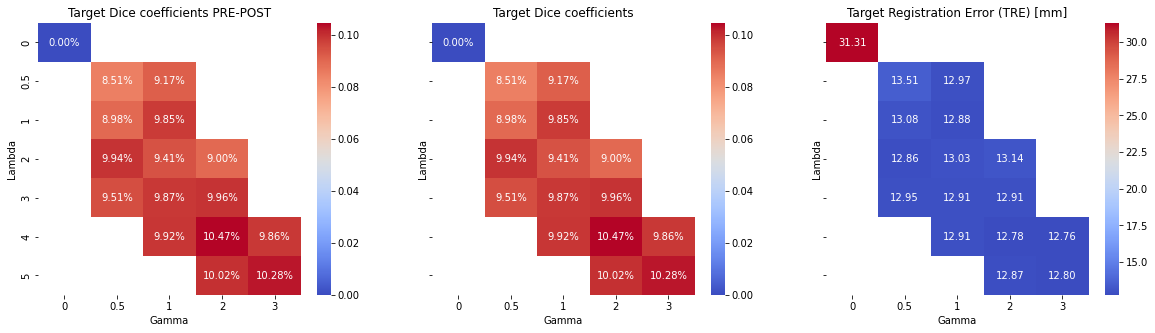

In [5]:
_, ax = plt.subplots(1, 3, figsize=(20, 5), sharey='all')

sns.heatmap(n_valid_dice, annot=True, fmt='.2%', xticklabels=g_labels, yticklabels=l_labels, cmap="coolwarm", ax=ax[0])
ax[0].set_title("% of decent dice (dice > 0)"), ax[0].set_xlabel("Gamma"), ax[0].set_ylabel("Lambda")

sns.heatmap(valid_dice_mean, annot=True, fmt='.2%', xticklabels=g_labels, yticklabels=l_labels, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Target Dice coefficients"), ax[1].set_xlabel("Gamma"), ax[1].set_ylabel("Lambda")
#for t in hm.texts: t.set_text(f"{t.get_text()}±{valid_dice_std[[int(p) for p in t.get_position()]]}")

sns.heatmap(valid_error_mean, annot=True, fmt='.2f', xticklabels=g_labels, yticklabels=l_labels, cmap="coolwarm", ax=ax[2])
ax[2].set_title("Target Registration Error (TRE) [mm]"), ax[2].set_xlabel("Gamma"), ax[2].set_ylabel("Lambda")

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(15, 9), sharey='all')

sns.heatmap(prostate_dice_def_mean, annot=True, fmt='.2%', xticklabels=g_labels, yticklabels=l_labels, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Prostate Dice coefficients PRE-POST"), ax[0].set_xlabel("Gamma"), ax[0].set_ylabel("Lambda")

sns.heatmap(prostate_dice_mean, annot=True, fmt='.2%', xticklabels=g_labels, yticklabels=l_labels, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Prostate Dice coefficients"), ax[1].set_xlabel("Gamma"), ax[1].set_ylabel("Lambda")

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

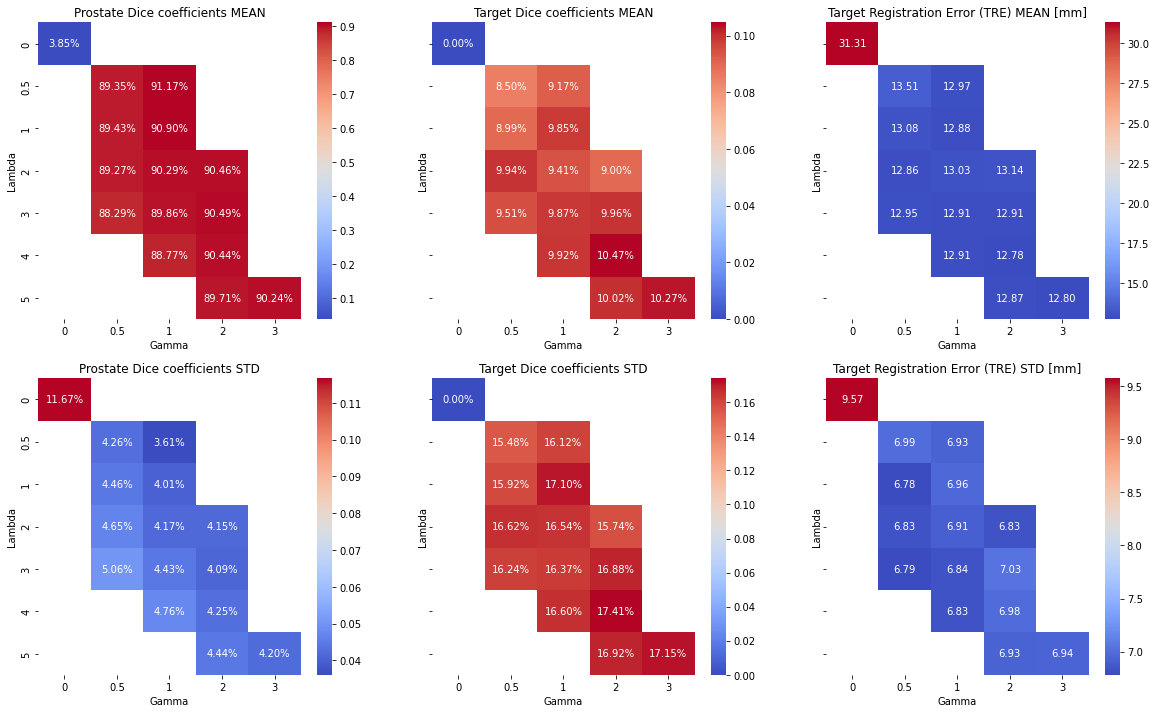

In [9]:
_, ax = plt.subplots(2, 3, figsize=(20, 12), sharey='all')

sns.heatmap(prostate_dice_mean, annot=True, fmt='.2%', xticklabels=g_labels, yticklabels=l_labels, cmap="coolwarm", ax=ax[0, 0])
ax[0, 0].set_title("Prostate Dice coefficients MEAN"), ax[0, 0].set_xlabel("Gamma"), ax[0, 0].set_ylabel("Lambda")

sns.heatmap(prostate_dice_std, annot=True, fmt='.2%', xticklabels=g_labels, yticklabels=l_labels, cmap="coolwarm", ax=ax[1, 0])
ax[1, 0].set_title("Prostate Dice coefficients STD"), ax[1, 0].set_xlabel("Gamma"), ax[1, 0].set_ylabel("Lambda")

sns.heatmap(valid_dice_mean, annot=True, fmt='.2%', xticklabels=g_labels, yticklabels=l_labels, cmap="coolwarm", ax=ax[0, 1])
ax[0, 1].set_title("Target Dice coefficients MEAN"), ax[0, 1].set_xlabel("Gamma"), ax[0, 1].set_ylabel("Lambda")

sns.heatmap(valid_dice_std, annot=True, fmt='.2%', xticklabels=g_labels, yticklabels=l_labels, cmap="coolwarm", ax=ax[1, 1])
ax[1, 1].set_title("Target Dice coefficients STD"), ax[1, 1].set_xlabel("Gamma"), ax[1, 1].set_ylabel("Lambda")

sns.heatmap(valid_error_mean, annot=True, fmt='.2f', xticklabels=g_labels, yticklabels=l_labels, cmap="coolwarm", ax=ax[0, 2])
ax[0, 2].set_title("Target Registration Error (TRE) MEAN [mm]"), ax[0, 2].set_xlabel("Gamma"), ax[0, 2].set_ylabel("Lambda")

sns.heatmap(valid_error_std, annot=True, fmt='.2f', xticklabels=g_labels, yticklabels=l_labels, cmap="coolwarm", ax=ax[1, 2])
ax[1, 2].set_title("Target Registration Error (TRE) STD [mm]"), ax[1, 2].set_xlabel("Gamma"), ax[1, 2].set_ylabel("Lambda")

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

OLD PLOTS

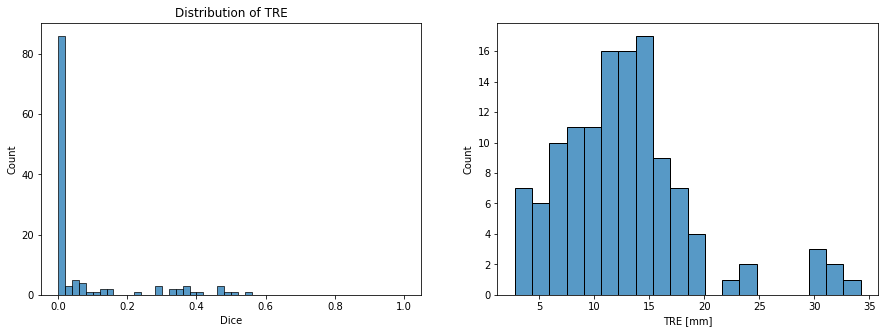

In [10]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(results["dice"], bins=50, binrange=(0.0, 1.0), ax=ax[0])
ax[0].set_title("Distribution of Dice coefficients"), ax[0].set_xlabel("Dice")

sns.histplot(results["error"], bins=20, ax=ax[1])
ax[0].set_title("Distribution of TRE"), ax[1].set_xlabel("TRE [mm]")

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

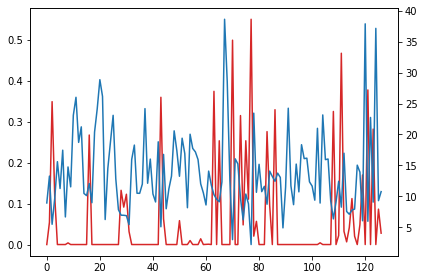

In [36]:
x = list(range(len(results["dice"])))
fig, ax1 = plt.subplots()
ax1.plot(x, results["dice"], 'tab:red')
ax2 = ax1.twinx()
ax2.plot(x, results["error"], 'tab:blue')
fig.tight_layout()
plt.show()

Show slices

In [ ]:
n_slice = 30
images = [img[0, :, :, n_slice * 2].squeeze() for img in [test_input_target, test_pred_target, test_output_target]]
titles = ['moving_target', 'moved_target', 'fixed_target']
_ = ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, grid=(1, 3), width=8)

In [16]:
test_pred = model.predict(test_input)

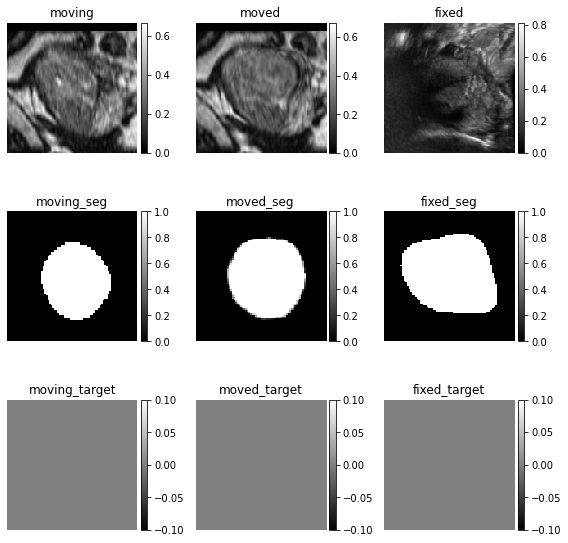

In [17]:
n_slice = 56
images = [img[0, :, :, n_slice * 2].squeeze() for img in [test_input[0], test_pred[0], test_input[1]]]
images += [img[0, :, :, n_slice].squeeze() for img in [test_input[2], test_pred[2], test_output[2]]]
images += [img[0, :, :, n_slice * 2].squeeze() for img in [test_input_target, test_pred_target, test_output_target]]
titles = ['moving', 'moved', 'fixed', 'moving_seg', 'moved_seg', 'fixed_seg', 'moving_target', 'moved_target', 'fixed_target']
_ = ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, grid=(3, 3), width=8)